In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib import pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [2]:
def get_file_names(folder):
    #Listing entries present in given folder
    entries = os.listdir(folder)
    for i in entries:
        if 'csv' not in i:
            entries.remove(i)
    return sorted(entries, reverse=True)[0:12]

train_path = "../split_datasets/train/"
test_path = "../split_datasets/test/"
val_path = "../split_datasets/validation/"

train_files = get_file_names(train_path)
test_files = get_file_names(test_path)
val_files = get_file_names(val_path)

frames = []
for i in train_files:
    frames.append(pd.read_csv(train_path+i)[0:1])
train_df = pd.concat(frames, sort=True)
train_df = train_df.drop(columns="id")
train_df = train_df.drop(columns="last_scraped")
train_df = train_df.fillna(0)

frames = []
for i in test_files:
    frames.append(pd.read_csv(test_path+i))
test_df = pd.concat(frames, sort=True)
test_df = test_df.drop(columns="id")
test_df = test_df.drop(columns="last_scraped")
test_df = test_df.fillna(0)

frames = []
for i in val_files:
    frames.append(pd.read_csv(val_path+i))
val_df = pd.concat(frames, sort=True)
val_df = val_df.drop(columns="id")
val_df = val_df.drop(columns="last_scraped")
val_df = val_df.fillna(0)

minimum = min(train_df['price'].min(), test_df['price'].min(), val_df['price'].min())
maximum = max(train_df['price'].max(), test_df['price'].max(), val_df['price'].max())

train_df['price'] = (train_df['price'] - minimum)/(maximum - minimum)
train_df = train_df.reset_index(drop=True)
test_df['price'] = (test_df['price'] - minimum)/(maximum - minimum)
test_df = test_df.reset_index(drop=True)
val_df['price'] = (val_df['price'] - minimum)/(maximum - minimum)
val_df = val_df.reset_index(drop=True)

print(minimum, maximum)

36 349


In [3]:
class airbnb_dataset (Dataset):
    def __init__(self, df, purpose):
        self.df = df
        self.price = self.df["price"]
        self.df = self.df.drop(columns="price")
        self.purpose = purpose
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # Returns specific sample as a dict
        if torch.is_tensor(index):
            index = index.tolist()
        sample = torch.tensor(self.df.iloc[index]).float()
        label = torch.tensor([self.price.iloc[index]]).float()
        return {"sample": sample, "label": label}

In [4]:
train_ds = airbnb_dataset(train_df, "train")
test_ds = airbnb_dataset(test_df, "test")
val_ds = airbnb_dataset(val_df, "test")

train_loader = DataLoader(train_ds, batch_size=1000, shuffle=True, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1000, shuffle=True, num_workers=4)

In [5]:
class airbnb_net (nn.Module):
    def __init__(self):
        super(airbnb_net, self).__init__()
        self.layer1 = nn.Linear(264, 528)
        self.layer2 = nn.Linear(528, 528)
        self.layer3 = nn.Linear(528, 350)
        self.layer4 = nn.Linear(350, 200)
        self.layer5 = nn.Linear(50, 1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        #x = torch.relu(self.layer2(x))
        #x = torch.relu(self.layer3(x))
        #x = torch.sigmoid(self.layer4(x))
        return self.layer5(x)

In [6]:
def train(net, train_loader, val_loader, bounds):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum = 0.9)
    
    print("Starting Training...")
    start_time = time.time()
    epochs, losses = [], []
    
    for epoch in range(200):
        epoch_loss = 0
        epoch_time = time.time()
        batch_loss = 0
        batch_time = time.time()
        for i, data in enumerate(train_loader):
            sample = data["sample"]
            label = data["label"]
            output = net(sample)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            batch_loss += loss.item()
            epoch_loss += loss.item()
            break
            if i % 10 == 0:
                batch_loss = batch_loss/10
                print("---[ITER %d] loss: %.6f  time: %.3f" % (i, batch_loss, time.time()-batch_time))
                batch_loss = 0
                batch_time = time.time()
        epoch_loss /= len(train_loader)
        
        epochs.append(epoch)
        losses.append(epoch_loss)
        
        print("[EPOCH %d] loss: %.6f  time: %.3f" % (epoch+1, epoch_loss, time.time()-epoch_time))
        
        if epoch % 5 == 0:
            plt.title("Training Curve")
            plt.plot(losses, label="Train")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.show()
        
    print("=========================================")
    print("Training Completed...")
    print("[FINAL] loss: %.6f  time: %.3f" % (epoch_loss, time.time()-start_time))
          
        
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    
'''
    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
'''            

'\n    plt.title("Training Curve")\n    plt.plot(epochs, train_acc, label="Train")\n    plt.plot(epochs, valid_acc, label="Validation")\n    plt.xlabel("Epoch")\n    plt.ylabel("Accuracy")\n    plt.legend(loc=\'best\')\n    plt.show()\n'

In [7]:
def get_error(model, train_loader, val_loader, threshold, bounds):
    train_samples = 0
    train_error = 0
    train_accuracy = 0
    for i, data in enumerate(train_loader):
        sample = data["sample"]
        label = data["label"]
        output = net(sample)
        error = abs(label-output)
        accurate = (error < float(threshold)/float(bounds[1]-bounds[0]))
        train_samples += len(label)
        train_error += error.sum().item()
        train_accuracy += accurate.sum().item()
    avg_train_error = float(train_error)/float(train_samples)*(bounds[1]-bounds[0])
    avg_train_accuracy = float(train_accuracy)/float(train_samples)
    
    val_samples = 0
    val_error = 0
    val_accuracy = 0
    for i, data in enumerate(val_loader):
        sample = data["sample"]
        label = data["label"]
        output = net(sample)
        error = abs(label-output)
        accurate = (error < float(threshold)/float(bounds[1]-bounds[0]))
        val_samples += len(label)
        val_error += error.sum().item()
        val_accuracy += accurate.sum().item()
    avg_val_error = float(val_error)/float(vakl_samples)*(bounds[1]-bounds[0])
    avg_val_accuracy = float(val_accuracy)/float(val_samples)
    return avg_train_error, avg_train_accuracy, avg_val_error, avg_val_accuracy

In [8]:
net = airbnb_net()

Starting Training...
[EPOCH 1] loss: 42.572940  time: 0.411


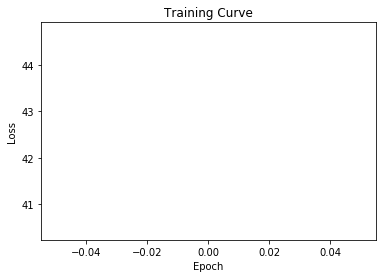

[EPOCH 2] loss: 21968.992188  time: 0.108
[EPOCH 3] loss: 0.008620  time: 0.093
[EPOCH 4] loss: 0.014030  time: 0.156
[EPOCH 5] loss: 0.020013  time: 0.109
[EPOCH 6] loss: 0.026295  time: 0.103


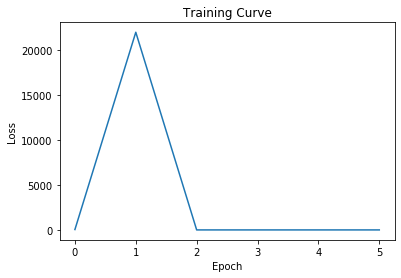

[EPOCH 7] loss: 0.032669  time: 0.133
[EPOCH 8] loss: 0.038982  time: 0.113
[EPOCH 9] loss: 0.045123  time: 0.115
[EPOCH 10] loss: 0.051016  time: 0.163
[EPOCH 11] loss: 0.056606  time: 0.136


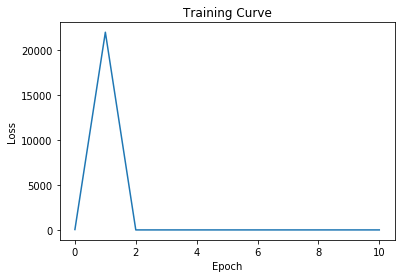

[EPOCH 12] loss: 0.061862  time: 0.116
[EPOCH 13] loss: 0.066767  time: 0.116
[EPOCH 14] loss: 0.071313  time: 0.118
[EPOCH 15] loss: 0.075503  time: 0.093
[EPOCH 16] loss: 0.079346  time: 0.111


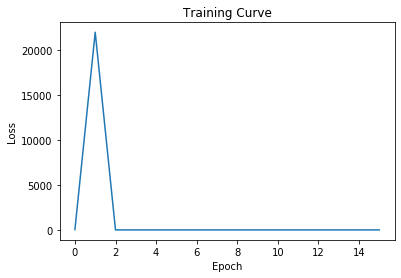

[EPOCH 17] loss: 0.082853  time: 0.101
[EPOCH 18] loss: 0.086041  time: 0.136
[EPOCH 19] loss: 0.088926  time: 0.103
[EPOCH 20] loss: 0.091528  time: 0.111
[EPOCH 21] loss: 0.093864  time: 0.107


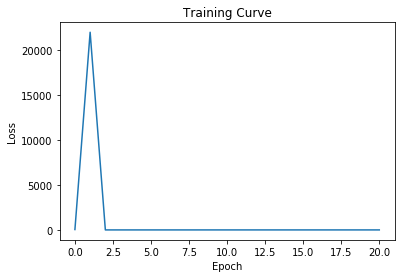

[EPOCH 22] loss: 0.095954  time: 0.079
[EPOCH 23] loss: 0.097816  time: 0.113
[EPOCH 24] loss: 0.099467  time: 0.180
[EPOCH 25] loss: 0.100925  time: 0.122
[EPOCH 26] loss: 0.102206  time: 0.111


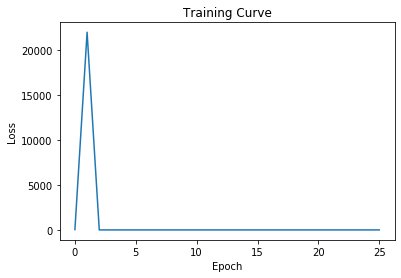

[EPOCH 27] loss: 0.103325  time: 0.080
[EPOCH 28] loss: 0.104295  time: 0.079
[EPOCH 29] loss: 0.105130  time: 0.090
[EPOCH 30] loss: 0.105842  time: 0.114
[EPOCH 31] loss: 0.106443  time: 0.087


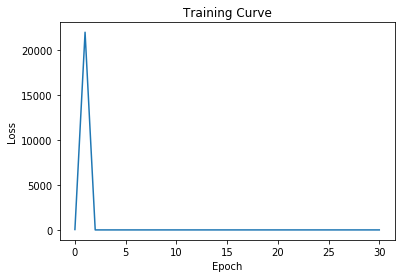

[EPOCH 32] loss: 0.106943  time: 0.083
[EPOCH 33] loss: 0.107350  time: 0.107
[EPOCH 34] loss: 0.107675  time: 0.099
[EPOCH 35] loss: 0.107924  time: 0.106
[EPOCH 36] loss: 0.108106  time: 0.119


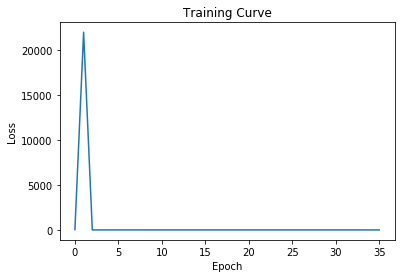

[EPOCH 37] loss: 0.108226  time: 0.088
[EPOCH 38] loss: 0.108291  time: 0.089
[EPOCH 39] loss: 0.108306  time: 0.099
[EPOCH 40] loss: 0.108276  time: 0.076
[EPOCH 41] loss: 0.108206  time: 0.069


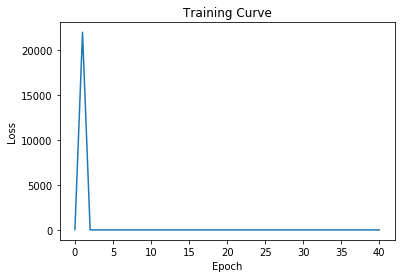

[EPOCH 42] loss: 0.108100  time: 0.085
[EPOCH 43] loss: 0.107961  time: 0.091
[EPOCH 44] loss: 0.107793  time: 0.123
[EPOCH 45] loss: 0.107599  time: 0.095
[EPOCH 46] loss: 0.107381  time: 0.080


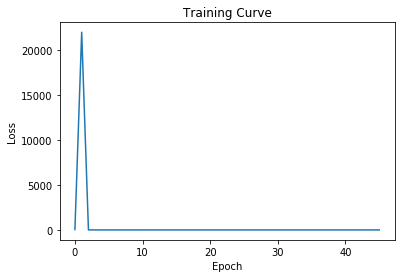

[EPOCH 47] loss: 0.107142  time: 0.073
[EPOCH 48] loss: 0.106885  time: 0.100
[EPOCH 49] loss: 0.106611  time: 0.085
[EPOCH 50] loss: 0.106322  time: 0.090
[EPOCH 51] loss: 0.106020  time: 0.078


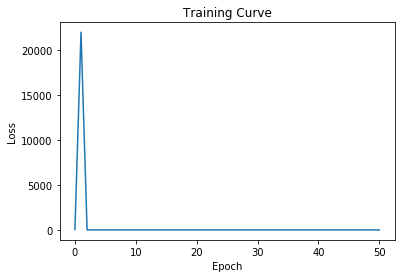

[EPOCH 52] loss: 0.105706  time: 0.068
[EPOCH 53] loss: 0.105382  time: 0.104
[EPOCH 54] loss: 0.105048  time: 0.094
[EPOCH 55] loss: 0.104706  time: 0.098
[EPOCH 56] loss: 0.104357  time: 0.094


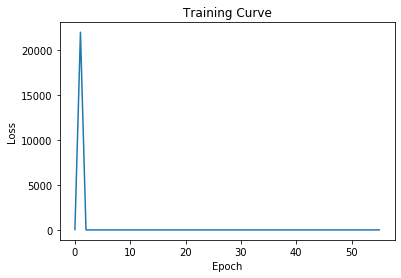

[EPOCH 57] loss: 0.104002  time: 0.090
[EPOCH 58] loss: 0.103642  time: 0.078
[EPOCH 59] loss: 0.103276  time: 0.093
[EPOCH 60] loss: 0.102907  time: 0.104
[EPOCH 61] loss: 0.102533  time: 0.098


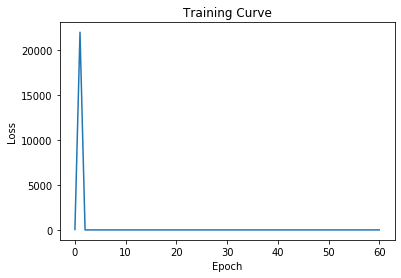

[EPOCH 62] loss: 0.102157  time: 0.072
[EPOCH 63] loss: 0.101778  time: 0.074
[EPOCH 64] loss: 0.101397  time: 0.070
[EPOCH 65] loss: 0.101015  time: 0.070
[EPOCH 66] loss: 0.100630  time: 0.068


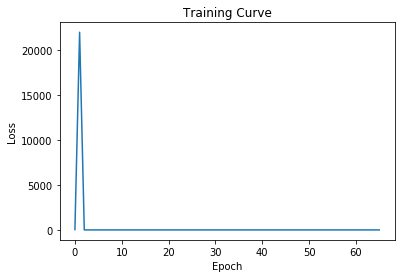

[EPOCH 67] loss: 0.100245  time: 0.106
[EPOCH 68] loss: 0.099859  time: 0.093
[EPOCH 69] loss: 0.099472  time: 0.114
[EPOCH 70] loss: 0.099085  time: 0.086
[EPOCH 71] loss: 0.098698  time: 0.084


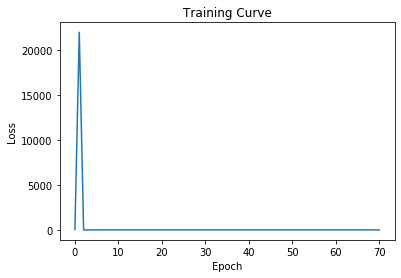

[EPOCH 72] loss: 0.098310  time: 0.067
[EPOCH 73] loss: 0.097923  time: 0.073
[EPOCH 74] loss: 0.097536  time: 0.073
[EPOCH 75] loss: 0.097149  time: 0.074
[EPOCH 76] loss: 0.096763  time: 0.080


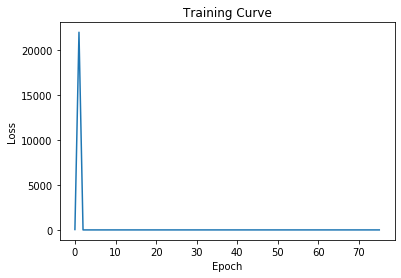

[EPOCH 77] loss: 0.096378  time: 0.125
[EPOCH 78] loss: 0.095993  time: 0.123
[EPOCH 79] loss: 0.095609  time: 0.100
[EPOCH 80] loss: 0.095226  time: 0.103
[EPOCH 81] loss: 0.094844  time: 0.100


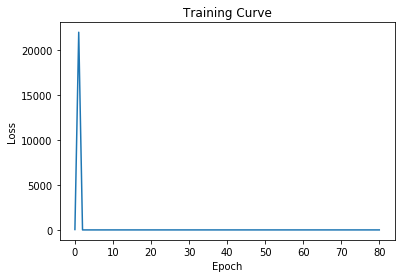

[EPOCH 82] loss: 0.094463  time: 0.112
[EPOCH 83] loss: 0.094083  time: 0.100
[EPOCH 84] loss: 0.093704  time: 0.107
[EPOCH 85] loss: 0.093327  time: 0.092
[EPOCH 86] loss: 0.092950  time: 0.090


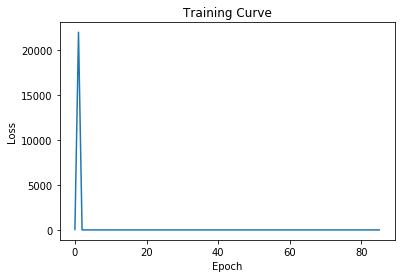

[EPOCH 87] loss: 0.092575  time: 0.098
[EPOCH 88] loss: 0.092200  time: 0.104
[EPOCH 89] loss: 0.091827  time: 0.089
[EPOCH 90] loss: 0.091456  time: 0.095
[EPOCH 91] loss: 0.091085  time: 0.108


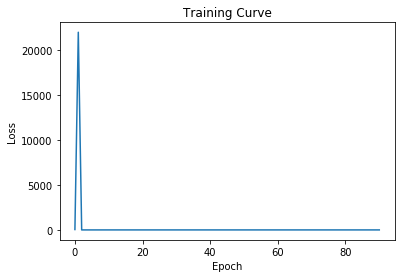

[EPOCH 92] loss: 0.090716  time: 0.088
[EPOCH 93] loss: 0.090349  time: 0.111
[EPOCH 94] loss: 0.089982  time: 0.099
[EPOCH 95] loss: 0.089617  time: 0.091
[EPOCH 96] loss: 0.089254  time: 0.085


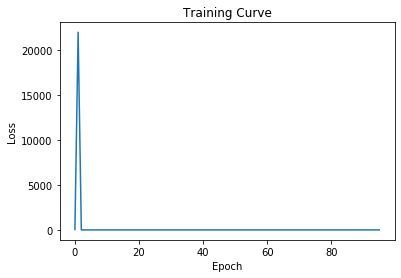

[EPOCH 97] loss: 0.088891  time: 0.099
[EPOCH 98] loss: 0.088530  time: 0.106
[EPOCH 99] loss: 0.088171  time: 0.115
[EPOCH 100] loss: 0.087813  time: 0.099
[EPOCH 101] loss: 0.087456  time: 0.104


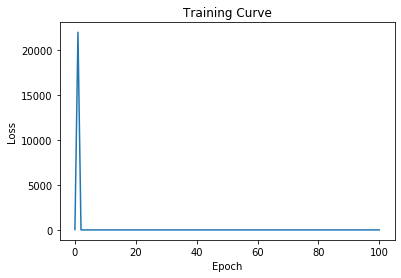

[EPOCH 102] loss: 0.087101  time: 0.091
[EPOCH 103] loss: 0.086747  time: 0.131
[EPOCH 104] loss: 0.086394  time: 0.107
[EPOCH 105] loss: 0.086043  time: 0.122
[EPOCH 106] loss: 0.085693  time: 0.205


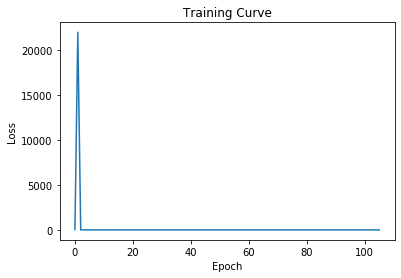

[EPOCH 107] loss: 0.085344  time: 0.077
[EPOCH 108] loss: 0.084997  time: 0.075
[EPOCH 109] loss: 0.084652  time: 0.093
[EPOCH 110] loss: 0.084307  time: 0.094
[EPOCH 111] loss: 0.083964  time: 0.090


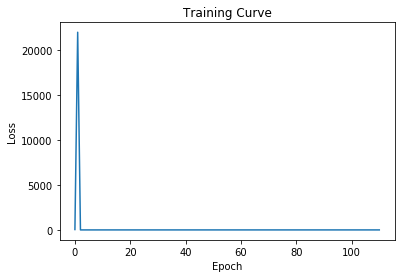

[EPOCH 112] loss: 0.083623  time: 0.150
[EPOCH 113] loss: 0.083282  time: 0.110
[EPOCH 114] loss: 0.082944  time: 0.120
[EPOCH 115] loss: 0.082606  time: 0.124
[EPOCH 116] loss: 0.082270  time: 0.105


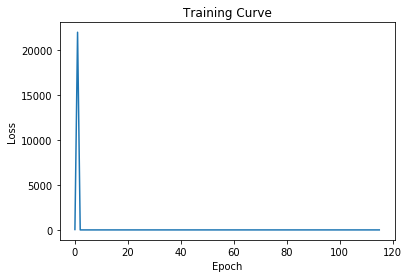

[EPOCH 117] loss: 0.081935  time: 0.115
[EPOCH 118] loss: 0.081602  time: 0.123
[EPOCH 119] loss: 0.081270  time: 0.101
[EPOCH 120] loss: 0.080939  time: 0.096
[EPOCH 121] loss: 0.080610  time: 0.094


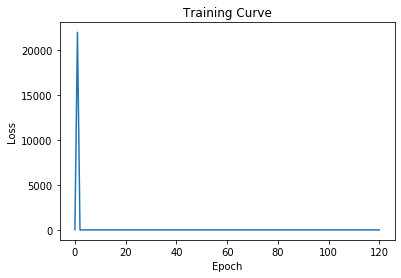

[EPOCH 122] loss: 0.080282  time: 0.111
[EPOCH 123] loss: 0.079955  time: 0.113
[EPOCH 124] loss: 0.079629  time: 0.113
[EPOCH 125] loss: 0.079305  time: 0.109
[EPOCH 126] loss: 0.078983  time: 0.090


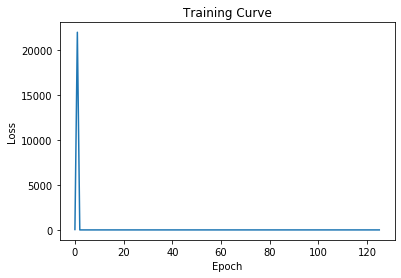

[EPOCH 127] loss: 0.078661  time: 0.076
[EPOCH 128] loss: 0.078341  time: 0.077
[EPOCH 129] loss: 0.078022  time: 0.099
[EPOCH 130] loss: 0.077704  time: 0.153
[EPOCH 131] loss: 0.077388  time: 0.117


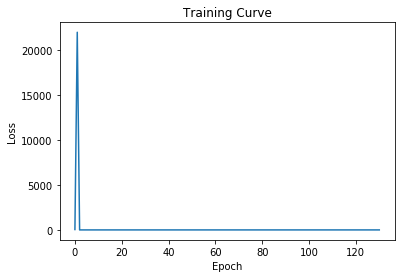

[EPOCH 132] loss: 0.077073  time: 0.079
[EPOCH 133] loss: 0.076759  time: 0.086
[EPOCH 134] loss: 0.076447  time: 0.099
[EPOCH 135] loss: 0.076136  time: 0.098
[EPOCH 136] loss: 0.075826  time: 0.111


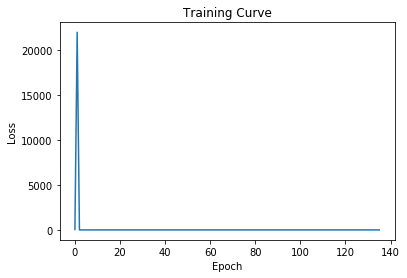

[EPOCH 137] loss: 0.075517  time: 0.091
[EPOCH 138] loss: 0.075210  time: 0.141
[EPOCH 139] loss: 0.074904  time: 0.141
[EPOCH 140] loss: 0.074599  time: 0.103
[EPOCH 141] loss: 0.074295  time: 0.096


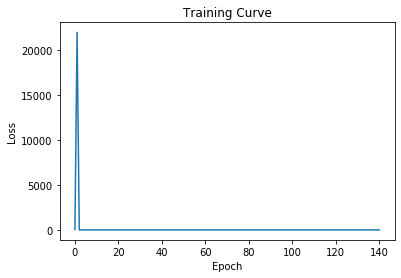

[EPOCH 142] loss: 0.073993  time: 0.144
[EPOCH 143] loss: 0.073692  time: 0.160
[EPOCH 144] loss: 0.073392  time: 0.113
[EPOCH 145] loss: 0.073093  time: 0.116
[EPOCH 146] loss: 0.072795  time: 0.091


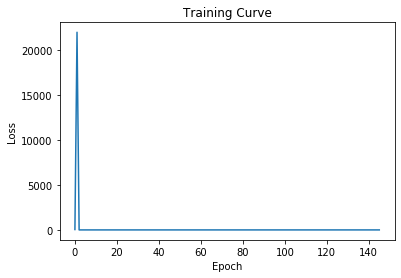

[EPOCH 147] loss: 0.072499  time: 0.146
[EPOCH 148] loss: 0.072204  time: 0.133
[EPOCH 149] loss: 0.071910  time: 0.135
[EPOCH 150] loss: 0.071617  time: 0.110
[EPOCH 151] loss: 0.071326  time: 0.137


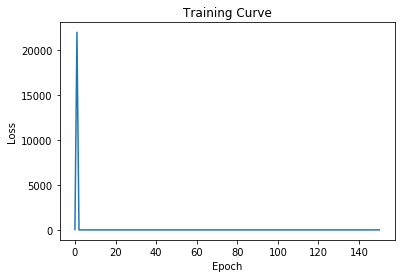

[EPOCH 152] loss: 0.071035  time: 0.107
[EPOCH 153] loss: 0.070746  time: 0.127
[EPOCH 154] loss: 0.070458  time: 0.104
[EPOCH 155] loss: 0.070171  time: 0.107
[EPOCH 156] loss: 0.069886  time: 0.124


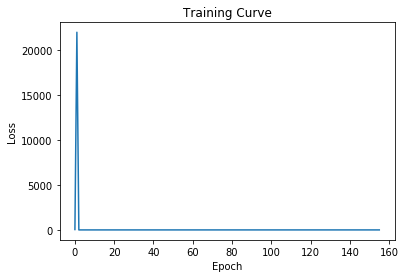

[EPOCH 157] loss: 0.069601  time: 0.080
[EPOCH 158] loss: 0.069318  time: 0.094
[EPOCH 159] loss: 0.069036  time: 0.119
[EPOCH 160] loss: 0.068755  time: 0.091
[EPOCH 161] loss: 0.068475  time: 0.077


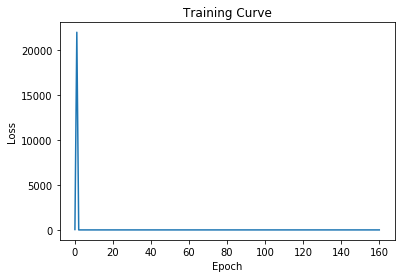

[EPOCH 162] loss: 0.068196  time: 0.071
[EPOCH 163] loss: 0.067918  time: 0.106
[EPOCH 164] loss: 0.067642  time: 0.176
[EPOCH 165] loss: 0.067367  time: 0.184
[EPOCH 166] loss: 0.067092  time: 0.085


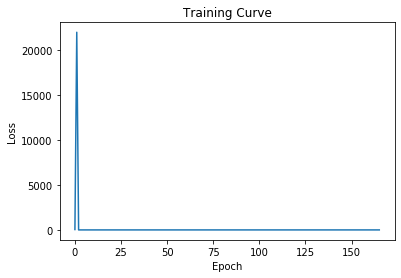

[EPOCH 167] loss: 0.066819  time: 0.236
[EPOCH 168] loss: 0.066547  time: 0.106
[EPOCH 169] loss: 0.066276  time: 0.087
[EPOCH 170] loss: 0.066007  time: 0.082
[EPOCH 171] loss: 0.065738  time: 0.082


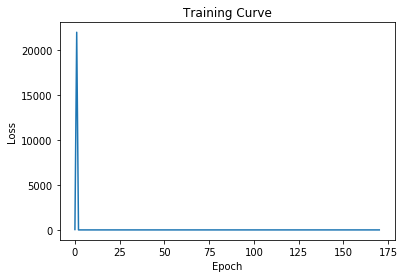

[EPOCH 172] loss: 0.065470  time: 0.171
[EPOCH 173] loss: 0.065204  time: 0.105
[EPOCH 174] loss: 0.064938  time: 0.100
[EPOCH 175] loss: 0.064674  time: 0.108
[EPOCH 176] loss: 0.064411  time: 0.116


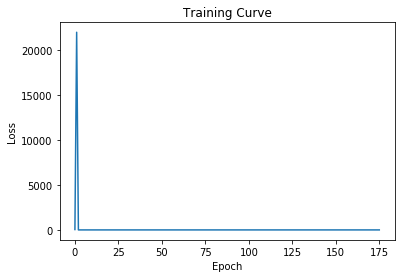

[EPOCH 177] loss: 0.064149  time: 0.121
[EPOCH 178] loss: 0.063887  time: 0.091
[EPOCH 179] loss: 0.063627  time: 0.094
[EPOCH 180] loss: 0.063368  time: 0.099
[EPOCH 181] loss: 0.063110  time: 0.114


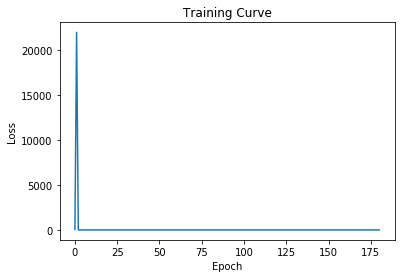

[EPOCH 182] loss: 0.062854  time: 0.084
[EPOCH 183] loss: 0.062598  time: 0.113
[EPOCH 184] loss: 0.062343  time: 0.131
[EPOCH 185] loss: 0.062089  time: 0.094
[EPOCH 186] loss: 0.061836  time: 0.093


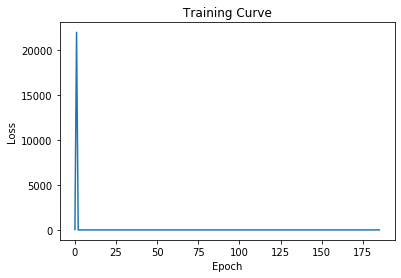

[EPOCH 187] loss: 0.061585  time: 0.075
[EPOCH 188] loss: 0.061334  time: 0.075
[EPOCH 189] loss: 0.061084  time: 0.080
[EPOCH 190] loss: 0.060836  time: 0.101
[EPOCH 191] loss: 0.060588  time: 0.128


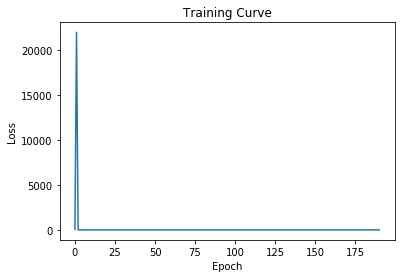

[EPOCH 192] loss: 0.060341  time: 0.091
[EPOCH 193] loss: 0.060096  time: 0.067
[EPOCH 194] loss: 0.059851  time: 0.070
[EPOCH 195] loss: 0.059607  time: 0.076
[EPOCH 196] loss: 0.059365  time: 0.124


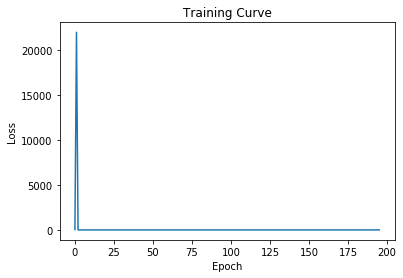

[EPOCH 197] loss: 0.059123  time: 0.104
[EPOCH 198] loss: 0.058882  time: 0.095
[EPOCH 199] loss: 0.058643  time: 0.073
[EPOCH 200] loss: 0.058404  time: 0.066
Training Completed...
[FINAL] loss: 0.058404  time: 30.407


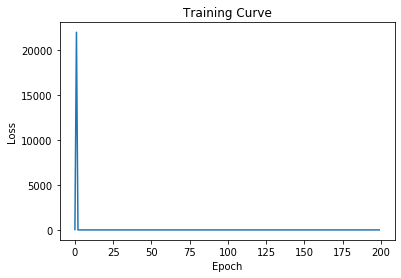

In [9]:
train(net, train_loader, val_loader, [minimum, maximum])

In [10]:
accum = 0
accum1 = 0
for i in range(10):
    error = net(train_ds[i]["sample"]).item() - train_ds[i]["label"].item()
    accum += error
    accum1 += abs(error)
    print(error)
print("Error:", accum/10)
bounds = [minimum, maximum]
print("Abs Error:", accum1/10*(bounds[1]-bounds[0]))

-0.835460901260376
-1.461659014225006
-0.7779529094696045
-1.2284321784973145
-0.6533522792160511
-1.145365059375763
-0.6373778376728296
-0.9217228889465332
-0.7105172052979469
-1.1485599279403687
Error: -0.9520400201901793
Abs Error: 297.9885263195261


In [ ]:
for i, data in enumerate(train_loader):
    print(len(data["label"]))
    break

In [ ]:
train_ds[4]["label"].item()
